## Traffic 5-minute station data loader

- **File**: `datasets/traffic/raw/d04_text_station_5min_2018_01_01.txt`
- **Schema (base columns)**:
  - **Timestamp**: Beginning of 5-min interval (MM/DD/YYYY HH24:MI:SS)
  - **Station**: Unique station identifier
  - **District**: District #
  - **Freeway**: Freeway #
  - **Direction of Travel**: N | S | E | W
  - **Lane Type**: CD | CH | FF | FR | HV | ML | OR
  - **Station Length**: Segment length covered by the station
  - **Samples**: Total good samples received for all lanes
  - **% Observed**: Percent of lane points observed (not imputed)
  - **Total Flow**: Sum of flows over the 5-min period
  - **Avg Occupancy**: Average occupancy (0-1)
  - **Avg Speed**: Flow-weighted average speed (mph)
- **Per-lane columns (repeated for each detected lane N)**:
  - **Lane N Samples**
  - **Lane N Flow**
  - **Lane N Avg Occ**
  - **Lane N Avg Speed**
  - **Lane N Observed**


In [1]:
import numpy as np 
import pandas as pd
from pathlib import Path

In [2]:
# Paths
project_root = Path("/home/kacperwyrwal/topological-flow-matching")
data_dir = project_root / "datasets" / "traffic"
metadata_file = data_dir / "d04_text_meta_2018_01_26.txt"
b1_file = data_dir / "PEMSD4_B1.npz"
raw_file = data_dir / "raw" / "d04_text_station_5min_2018_01_01.txt"


# Inspect the first row to determine total columns and lanes
sample_df = pd.read_csv(raw_file, header=None, nrows=1, low_memory=False)
total_columns = sample_df.shape[1]

base_columns = [
    "Timestamp",
    "Station",
    "District",
    "Freeway",
    "Direction of Travel",
    "Lane Type",
    "Station Length",
    "Samples",
    "% Observed",
    "Total Flow",
    "Avg Occupancy",
    "Avg Speed",
]

if (total_columns - len(base_columns)) % 5 != 0:
    raise ValueError(f"Unexpected column count: {total_columns}")

num_lanes = (total_columns - len(base_columns)) // 5

lane_columns = []
for lane_index in range(1, num_lanes + 1):
    lane_columns.extend([
        f"Lane {lane_index} Samples",
        f"Lane {lane_index} Flow",
        f"Lane {lane_index} Avg Occ",
        f"Lane {lane_index} Avg Speed",
        f"Lane {lane_index} Observed",
    ])

column_names = base_columns + lane_columns


# Load full dataset
df = pd.read_csv(
    raw_file,
    header=None,
    names=column_names,
    low_memory=False,
)

# Parse timestamp
df["Timestamp"] = pd.to_datetime(df["Timestamp"], format="%m/%d/%Y %H:%M:%S", errors="coerce")

# Quick sanity checks
print(f"Detected lanes: {num_lanes}")

# Take only the needed columns
df = df[['Timestamp', 'Station', 'Total Flow']]
df.head()

Detected lanes: 8


,Timestamp,Station,Total Flow
0,2018-01-01,400000,4.0
1,2018-01-01,400001,41.0
2,2018-01-01,400002,105.0
3,2018-01-01,400006,101.0
4,2018-01-01,400007,133.0


# Load the data from the experiment and matching sensor IDs

In [3]:
data = np.load('./PEMS04.npz')['data']



idx_to_id = {}

j_iter = iter(df['Station'].unique().tolist())
for i in range(data.shape[1]):
    flow_i = data[:288, i, 0]

    while True: 
        j = next(j_iter)
        candidate_flow_j = df[df['Station'] == j]['Total Flow'].values
        if np.all(candidate_flow_j == flow_i):
            print(f"Station {i} has the same flow as the {j}-th station")
            idx_to_id[i] = j
            break

id_to_idx = {v: k for k, v in idx_to_id.items()}

Station 0 has the same flow as the 400031-th station
Station 1 has the same flow as the 400071-th station
Station 2 has the same flow as the 400079-th station
Station 3 has the same flow as the 400100-th station
Station 4 has the same flow as the 400108-th station
Station 5 has the same flow as the 400122-th station
Station 6 has the same flow as the 400127-th station
Station 7 has the same flow as the 400164-th station
Station 8 has the same flow as the 400181-th station
Station 9 has the same flow as the 400184-th station
Station 10 has the same flow as the 400197-th station
Station 11 has the same flow as the 400221-th station
Station 12 has the same flow as the 400228-th station
Station 13 has the same flow as the 400231-th station
Station 14 has the same flow as the 400236-th station
Station 15 has the same flow as the 400237-th station
Station 16 has the same flow as the 400238-th station
Station 17 has the same flow as the 400248-th station
Station 18 has the same flow as the 40

# Load the metadata file and create numpy with longitude latitude coordinates

In [4]:
metadata = pd.read_csv(metadata_file, delimiter='\t', usecols=['ID', 'Longitude', 'Latitude'])


# take subset corresponding to the matching stations
metadata = metadata[metadata['ID'].isin(id_to_idx.keys())]

# Load in the incidence matrix and convert everything to a networkx graph

In [5]:
import networkx as nx


# load boundary operator
b1 = np.load(b1_file)['arr_0']


# Create incidence matrix and remove self-loops
A = - b1 @ b1.T
np.fill_diagonal(A, 0)


# Create an undirected graph from the incidence matrix
G = nx.from_numpy_array(A)


# Assign coordinates to each node
nx.set_node_attributes(G, metadata.set_index(metadata['ID'].map(id_to_idx)).drop(columns='ID').to_dict(orient='index'))


In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from pyproj import Transformer
import contextily as cx


def plot_graph_with_basemap(G, c='black', buffer_km=10, source=cx.providers.CartoDB.PositronNoLabels):
    """
    Plot a NetworkX graph whose nodes have 'lon' and 'lat' (degrees),
    with a basemap background covering ~tens of km around the graph.
    tiles: any contextily provider key, e.g.
        "Esri.WorldImagery", "Stamen.Terrain", "CartoDB.Positron", etc.
    """
    # 1) grab lon/lat from node attrs
    nodes = list(G.nodes())
    lons = np.array([G.nodes[n]["Longitude"] for n in nodes], dtype=float)
    lats = np.array([G.nodes[n]["Latitude"] for n in nodes], dtype=float)

    # 2) reproject to Web Mercator (meters)
    transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)
    xs, ys = transformer.transform(lons, lats)
    pos3857 = {n: (x, y) for n, x, y in zip(nodes, xs, ys)}

    # 3) build edge segments for fast plotting
    segs = []
    for u, v in G.edges():
        x1, y1 = pos3857[u]
        x2, y2 = pos3857[v]
        segs.append([(x1, y1), (x2, y2)])

    # 4) figure extents + buffer (meters)
    xmin, xmax = xs.min(), xs.max()
    ymin, ymax = ys.min(), ys.max()
    buf = max(buffer_km * 1000.0, 1.0)  # at least 1 m
    xlim = (xmin - buf, xmax + buf)
    ylim = (ymin - buf, ymax + buf)

    # 5) plot
    fig, ax = plt.subplots(figsize=(4, 4))

    # basemap first (so lines render crisper on top)
    ax.set_xlim(*xlim); ax.set_ylim(*ylim)
    cx.add_basemap(ax, source=source, crs="EPSG:3857", attribution=False)

    # edges
    if segs:
        lc = LineCollection(segs, linewidths=0.5, alpha=1.0, color='darkgray')
        ax.add_collection(lc)

    # nodes
    ax.scatter(xs, ys, s=3, zorder=3, c=c)

    ax.set_axis_off()
    ax.set_title(f"Traffic Dataset Graph")
    plt.tight_layout()
    plt.show()


# Make plots

In [80]:
import os 
from cartopy import crs as ccrs
from matplotlib.collections import PolyCollection, LineCollection


PLOTS_DIR = "./plots"
os.makedirs(PLOTS_DIR, exist_ok=True)


INCH_OVER_CM = 2.54
PAGE_WIDTH = 14.8 / INCH_OVER_CM
PAGE_HEIGHT = 24.5 / INCH_OVER_CM


plt.rcParams.update({
    "font.size": 10,          # default text
    "axes.titlesize": 12,     # figure title
    "axes.labelsize": 10,     # x and y labels
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
})

plt.rcParams.update({
    "text.usetex": True,              # use LaTeX for all text
    "font.family": "serif",           # LaTeX serif font (Computer Modern by default)
    "axes.unicode_minus": False,      # ensure minus signs render correctly
})


%config InlineBackend.figure_format = 'retina'   # high quality
plt.rcParams["figure.dpi"] = 150



def save_figure(fig: plt.Figure, filename: str): 
    fig.savefig(os.path.join(PLOTS_DIR, filename), transparent=True, bbox_inches="tight")

# 1. Plot initial graph

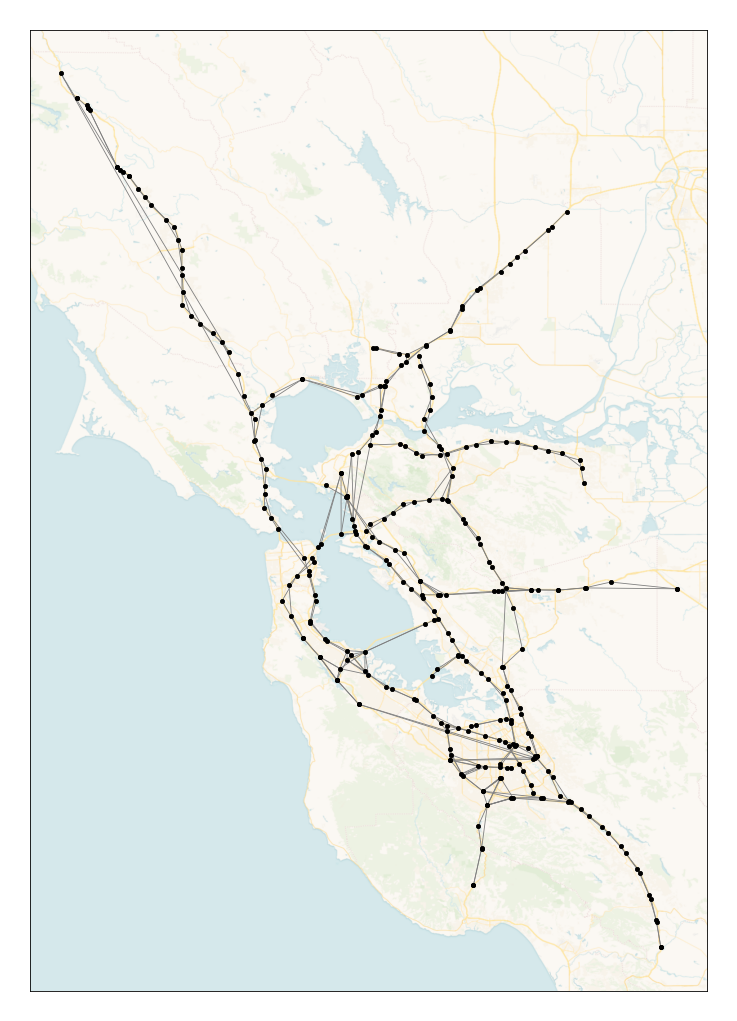

In [94]:
# projection 
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)


# create figure 
width = PAGE_WIDTH / 2
height = width / 0.7
fig, ax = plt.subplots(figsize=(width, height))



# vertices 
color = 'black'
s = 1.0
zorder = 2
node_to_lon = nx.get_node_attributes(G, 'Longitude')
node_to_lat = nx.get_node_attributes(G, 'Latitude')
for (i, lon), (j, lat) in zip(node_to_lon.items(), node_to_lat.items()):
    node_to_lon[i], node_to_lat[j] = transformer.transform(lon, lat)

lon, lat = list(node_to_lon.values()), list(node_to_lat.values())
ax.scatter(lon, lat, s=s, zorder=zorder, c=color, linewidth=0.2)



# edges 
color = 'tab:grey'
linewidth = 0.2
zorder = 1
alpha = 1.0

lines = []
for i, j in G.edges:
    lines.append([[node_to_lon[i], node_to_lat[i]], [node_to_lon[j], node_to_lat[j]]])
lc = LineCollection(lines, colors=color, linewidths=linewidth, zorder=zorder, alpha=alpha)
ax.add_collection(lc)



# basemap 
zorder = 0
cx.add_basemap(ax, source=cx.providers.CartoDB.VoyagerNoLabels, crs="EPSG:3857", attribution=False, zorder=zorder, zoom=10)



# Figure details: 
# Remove ticks 
ax.set_xticks([])
ax.set_yticks([])
for spine in ax.spines.values():
    spine.set_linewidth(0.2)



# Save 
save_figure(fig, "traffic-graph.pdf")

# 2. Plot simplicial complex

In [78]:
import scipy.sparse as sp
from scipy.spatial.distance import pdist, squareform
from numpy.linalg import inv, pinv


def get_adjacency_matrix(number_nodes: int = 307):
    PEMS_net_dataset = pd.read_csv('./distance.csv', header=0)
    PEMS_net_edges = PEMS_net_dataset.values[:, 0:2]
    A = np.zeros((number_nodes, number_nodes), dtype= np.float32)
    for i in range(PEMS_net_edges.shape[0]):
        A[int(PEMS_net_edges[i,0] -1 ), int(PEMS_net_edges[i,1] -1 )] = 1.
        A[int(PEMS_net_edges[i, 1] - 1), int(PEMS_net_edges[i, 0] -1 )] = 1.
    A = sp.csr_matrix(A)
    return A


def get_faces(G: nx.Graph):
    """
    Returns a list of the faces in an undirected graph
    """
    edges = list(G.edges)
    faces = []
    for i in range(len(edges)):
        for j in range(i+1, len(edges)):
            e1 = edges[i]
            e2 = edges[j]
            if e1[0] == e2[0]:
                shared = e1[0]
                e3 = (e1[1], e2[1])
            elif e1[1] == e2[0]:
                shared = e1[1]
                e3 = (e1[0], e2[1])
            elif e1[0] == e2[1]:
                shared = e1[0]
                e3 = (e1[1], e2[0])
            elif e1[1] == e2[1]:
                shared = e1[1]
                e3 = (e1[0], e2[0])
            else: # edges don't connect
                continue

            if e3[0] in G[e3[1]]: # if 3rd edge is in graph
                faces.append(tuple(sorted((shared, *e3))))
    return list(sorted(set(faces)))


def incidence_matrices(G, V, E, faces, edge_to_idx):
    """
    Returns incidence matrices B1 and B2

    :param G: NetworkX DiGraph
    :param V: list of nodes
    :param E: list of edges
    :param faces: list of faces in G
    :param edge_to_idx: dictionary mapping edges to their indices

    Returns B1 (|V| x |E|) and B2 (|E| x |faces|)
    B1[i][j]: -1 if node is is tail of edge j, 1 if node is head of edge j, else 0 (tail -> head) (smaller -> larger)
    B2[i][j]: 1 if edge i appears sorted in face j, -1 if edge i appears reversed in face j, else 0; given faces with sorted node order
    """
    B1 = np.array(nx.incidence_matrix(G, nodelist=V, edgelist=E, oriented=True).todense())
    B2 = np.zeros([len(E),len(faces)])

    for f_idx, face in enumerate(faces): # face is sorted
        edges = [face[:-1], face[1:], [face[0], face[2]]]
        e_idxs = [edge_to_idx[tuple(e)] for e in edges]

        B2[e_idxs[:-1], f_idx] = 1
        B2[e_idxs[-1], f_idx] = -1
    return B1, B2


def compute_D2(B):
    """
    Computes D2 = max(diag(dot(|B|, 1)), I)
    """
    B_rowsum = np.abs(B).sum(axis=1)

    D2 = np.diag(np.maximum(B_rowsum, 1))
    return D2

def compute_D1(B1, D2):
    """
    Computes D1 = 2 * max(diag(|B1|) .* D2
    """
    rowsum = (np.abs(B1) @ D2).sum(axis=1)
    D1 = 2 * np.diag(rowsum)

    return D1


def compute_bunch_matrices(B1, B2):
    """
    Computes normalized A0 and A1 matrices (up and down),
        and returns all matrices needed for Bunch model shift operators
    """
    # D matrices
    D2_2 = compute_D2(B2)
    D2_1 = compute_D2(B1)
    D3_n = np.identity(B1.shape[1]) # (|E| x |E|)
    D1 = compute_D1(B1, D2_2)
    D3 = np.identity(B2.shape[1]) / 3 # (|F| x |F|)

    # L matrices
    D1_pinv = pinv(D1)
    D2_2_inv = inv(D2_2)

    L1u = D2_2 @ B1.T @ D1_pinv @ B1
    L1d = B2 @ D3 @ B2.T @ D2_2_inv
    L1f = L1u + L1d

    return L1f


def node_corr_cosine(adj, feat):
    """calculate edge cosine distance"""
    # prod = np.dot(feat, feat.T)
    distance = squareform(pdist(feat, 'cosine'))
    edge_feat = distance[np.nonzero(sp.triu(adj, k=1))]
    ret = edge_feat.reshape((len(edge_feat), 1))
    return ret


def compute_hodge_matrix(data):
    g = nx.Graph()
    g.add_nodes_from([i for i in range(len(data.nodes))])
    edge_index_ = np.array(data.edges).transpose()
    edge_index = [(edge_index_[0, i], edge_index_[1, i]) for i in
                  range(np.shape(edge_index_)[1])]
    g.add_edges_from(edge_index)

    edge_to_idx = {edge: i for i, edge in enumerate(g.edges)}

    B1, B2 = incidence_matrices(g, sorted(g.nodes), sorted(g.edges), get_faces(g), edge_to_idx)

    return B1, B2

In [79]:
V = list(G.nodes())
E = list(G.edges())
F = get_faces(G)
edge_to_idx = {e: i for i, e in enumerate(E)}

B1, B2 = incidence_matrices(G, V, E, F, edge_to_idx)
L = compute_bunch_matrices(B1, B2)

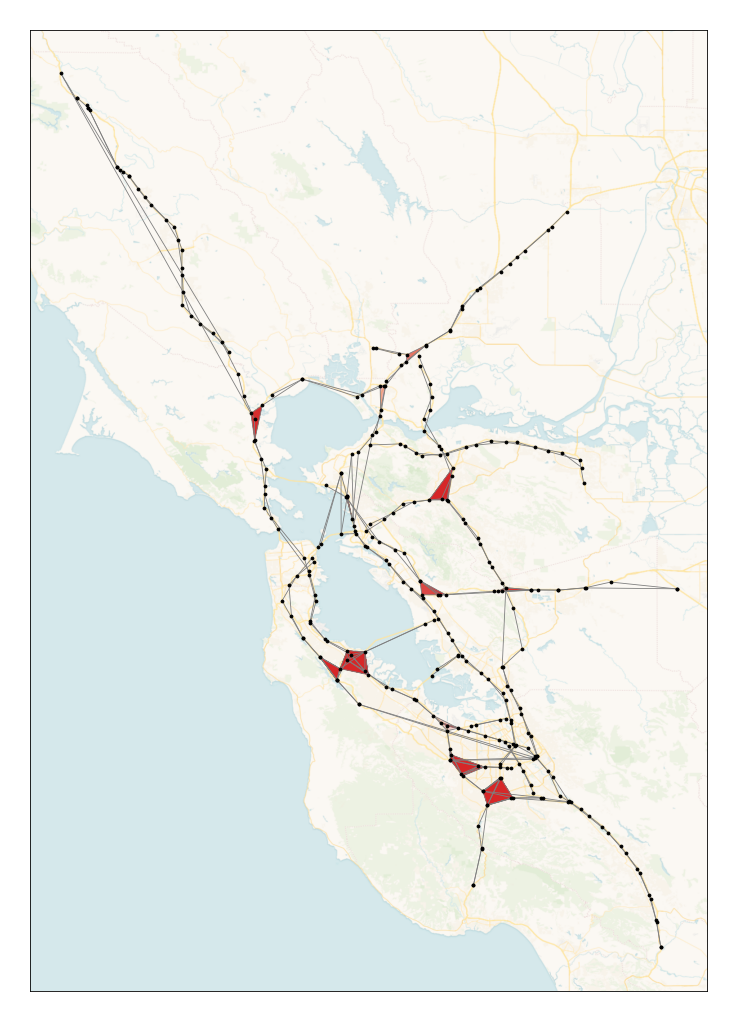

In [93]:
# projection 
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)


# create figure 
width = PAGE_WIDTH / 2
height = width / 0.7
fig, ax = plt.subplots(figsize=(width, height))



# vertices 
color = 'black'
s = 0.5
zorder = 2
node_to_lon = nx.get_node_attributes(G, 'Longitude')
node_to_lat = nx.get_node_attributes(G, 'Latitude')
for (i, lon), (j, lat) in zip(node_to_lon.items(), node_to_lat.items()):
    node_to_lon[i], node_to_lat[j] = transformer.transform(lon, lat)

lon, lat = list(node_to_lon.values()), list(node_to_lat.values())
ax.scatter(lon, lat, s=s, zorder=zorder, c=color, linewidth=0.2)



# edges 
color = 'tab:grey'
linewidth = 0.2
zorder = 1
alpha = 1.0

lines = []
for i, j in G.edges:
    lines.append([[node_to_lon[i], node_to_lat[i]], [node_to_lon[j], node_to_lat[j]]])
lc = LineCollection(lines, colors=color, linewidths=linewidth, zorder=zorder, alpha=alpha)
ax.add_collection(lc)


# triangles
zorder = 0
triangles = F
polys = []
for (i, j, k) in triangles:
    polys.append([
        [node_to_lon[i], node_to_lat[i]], 
        [node_to_lon[j], node_to_lat[j]], 
        [node_to_lon[k], node_to_lat[k]]
    ])

    # constant face color
    poly = PolyCollection(
        polys,
        facecolors='tab:red',
        edgecolors='tab:grey',
        linewidths=0.0,
        alpha=0.2,
        zorder=zorder,
    )
    ax.add_collection(poly)



# basemap 
zorder = -1
cx.add_basemap(ax, source=cx.providers.CartoDB.VoyagerNoLabels, crs="EPSG:3857", attribution=False, zorder=zorder, zoom=10)



# Figure details: 
# Remove ticks 
ax.set_xticks([])
ax.set_yticks([])
for spine in ax.spines.values():
    spine.set_linewidth(0.2)



# Save 
save_figure(fig, "traffic-simplicial_complex.pdf")

# 2. Plot input output

### Input

In [137]:
i = 16 * 60 // 5
x_node = np.load('./PEMS04.npz')['data'][i, :, 0]
x_edge = np.load('./PEMSD4_edge_features_matrix.npz')['arr_0'][i, :, 0]

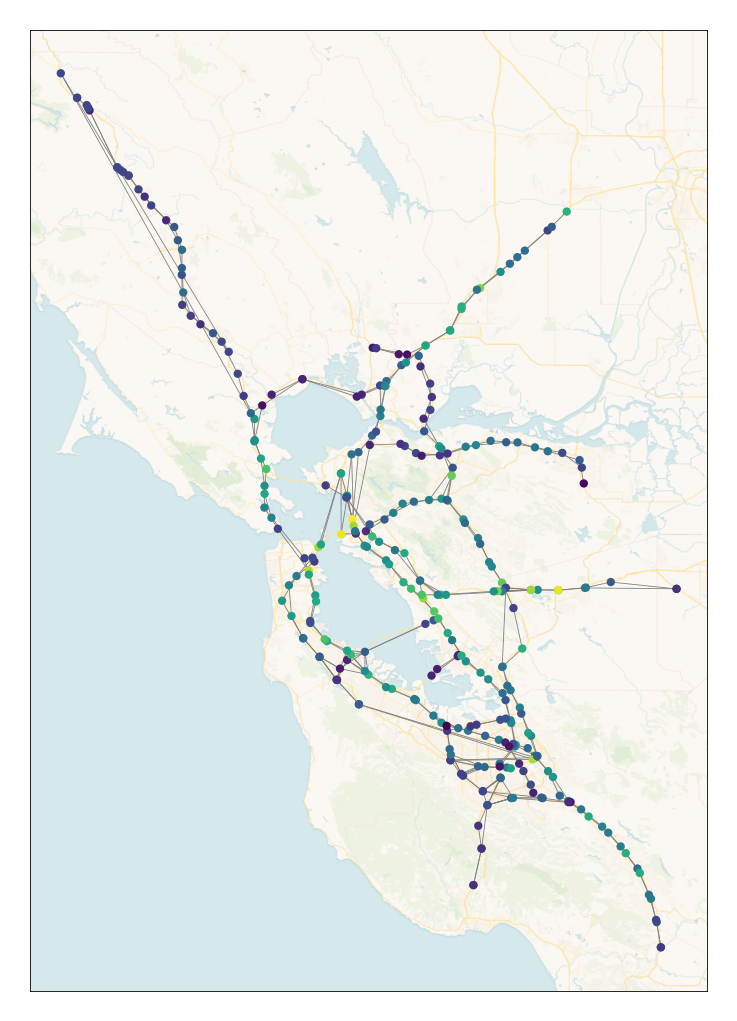

In [138]:
# projection 
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)


# create figure 
width = PAGE_WIDTH / 2
height = width / 0.7
fig, ax = plt.subplots(figsize=(width, height))



# vertices 
color = 'black'
s = 4.0
zorder = 2
node_to_lon = nx.get_node_attributes(G, 'Longitude')
node_to_lat = nx.get_node_attributes(G, 'Latitude')
for (i, lon), (j, lat) in zip(node_to_lon.items(), node_to_lat.items()):
    node_to_lon[i], node_to_lat[j] = transformer.transform(lon, lat)

lon, lat = list(node_to_lon.values()), list(node_to_lat.values())
c = x_node
ax.scatter(lon, lat, s=s, zorder=zorder, c=c, linewidth=0)



# edges 
color = 'tab:grey'
linewidth = 0.2
zorder = 1
alpha = 1.0

lines = []
for i, j in G.edges:
    lines.append([[node_to_lon[i], node_to_lat[i]], [node_to_lon[j], node_to_lat[j]]])
lc = LineCollection(lines, colors=color, linewidths=linewidth, zorder=zorder, alpha=alpha)
ax.add_collection(lc)



# basemap 
zorder = 0
cx.add_basemap(ax, source=cx.providers.CartoDB.VoyagerNoLabels, crs="EPSG:3857", attribution=False, zorder=zorder, zoom=10)



# Figure details: 
# Remove ticks 
ax.set_xticks([])
ax.set_yticks([])
for spine in ax.spines.values():
    spine.set_linewidth(0.2)



# Save 
save_figure(fig, "traffic-graph_with_node_features.pdf")

In [139]:
from matplotlib.colors import Normalize

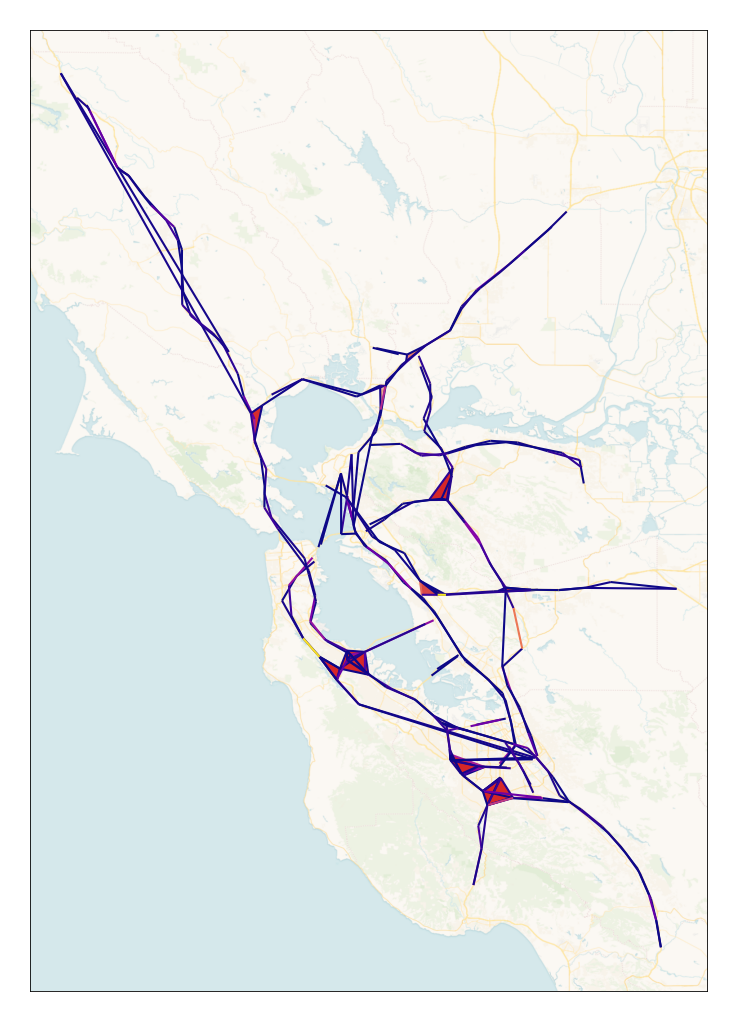

In [140]:
# projection 
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)


# create figure 
width = PAGE_WIDTH / 2
height = width / 0.7
fig, ax = plt.subplots(figsize=(width, height))



# vertices 
color = 'black'
s = 0.0
zorder = 2
node_to_lon = nx.get_node_attributes(G, 'Longitude')
node_to_lat = nx.get_node_attributes(G, 'Latitude')
for (i, lon), (j, lat) in zip(node_to_lon.items(), node_to_lat.items()):
    node_to_lon[i], node_to_lat[j] = transformer.transform(lon, lat)

lon, lat = list(node_to_lon.values()), list(node_to_lat.values())
ax.scatter(lon, lat, s=s, zorder=zorder, c=color, linewidth=0.0)



# edges 
linewidth = 0.5
zorder = 1
alpha = 1.0
cmap = plt.get_cmap('plasma')
norm = Normalize(vmin=x_edge.min(), vmax=x_edge.max())
colors = cmap(norm(x_edge))

lines = []
for i, j in G.edges:
    lines.append([[node_to_lon[i], node_to_lat[i]], [node_to_lon[j], node_to_lat[j]]])
lc = LineCollection(lines, colors=colors, linewidths=linewidth, zorder=zorder, alpha=alpha)
ax.add_collection(lc)


# triangles
zorder = 0
triangles = F
polys = []
for (i, j, k) in triangles:
    polys.append([
        [node_to_lon[i], node_to_lat[i]], 
        [node_to_lon[j], node_to_lat[j]], 
        [node_to_lon[k], node_to_lat[k]]
    ])

    # constant face color
    poly = PolyCollection(
        polys,
        facecolors='tab:red',
        edgecolors='tab:grey',
        linewidths=0.0,
        alpha=0.2,
        zorder=zorder,
    )
    ax.add_collection(poly)



# basemap 
zorder = -1
cx.add_basemap(ax, source=cx.providers.CartoDB.VoyagerNoLabels, crs="EPSG:3857", attribution=False, zorder=zorder, zoom=10)



# Figure details: 
# Remove ticks 
ax.set_xticks([])
ax.set_yticks([])
for spine in ax.spines.values():
    spine.set_linewidth(0.2)



# Save 
save_figure(fig, "simplicial_complex_with_edge_features.pdf")

In [135]:
len(F), len(G.edges)

(29, 340)

# Other stuff

In [ ]:
B1_used = np.load('./PEMSD4_B1.npz')['arr_0']
L_used = np.load('./PEMSD4_hodge_Laplacian.npz')['arr_0']
edge_x = np.load('./PEMSD4_edge_features_matrix.npz')['arr_0']
x = data


if (L == L_used).all():
    print("L is equal to the used L ✅")
else:
    print("L is not equal to the used L ❌")


if (B1 == B1_used).all():
    print("B1 is equal to the used B1 ✅")
else:
    print("B1 is not equal to the used B1 ❌")

L is not equal to the used L ❌
B1 is equal to the used B1 ✅


In [120]:
def plot_graph_with_basemap(G, c='black', edge_c='darkgray', buffer_km=10, source=cx.providers.CartoDB.PositronNoLabels, s=3):
    """
    Plot a NetworkX graph whose nodes have 'lon' and 'lat' (degrees),
    with a basemap background covering ~tens of km around the graph.
    tiles: any contextily provider key, e.g.
        "Esri.WorldImagery", "Stamen.Terrain", "CartoDB.Positron", etc.
    """
    # 1) grab lon/lat from node attrs
    nodes = list(G.nodes())
    lons = np.array([G.nodes[n]["Longitude"] for n in nodes], dtype=float)
    lats = np.array([G.nodes[n]["Latitude"] for n in nodes], dtype=float)

    # 2) reproject to Web Mercator (meters)
    transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)
    xs, ys = transformer.transform(lons, lats)
    pos3857 = {n: (x, y) for n, x, y in zip(nodes, xs, ys)}

    # 3) build edge segments for fast plotting
    segs = []
    for u, v in G.edges():
        x1, y1 = pos3857[u]
        x2, y2 = pos3857[v]
        segs.append([(x1, y1), (x2, y2)])

    # 4) figure extents + buffer (meters)
    xmin, xmax = xs.min(), xs.max()
    ymin, ymax = ys.min(), ys.max()
    buf = max(buffer_km * 1000.0, 1.0)  # at least 1 m
    xlim = (xmin - buf, xmax + buf)
    ylim = (ymin - buf, ymax + buf)

    # 5) plot
    fig, ax = plt.subplots(figsize=(4, 4), dpi=300)

    # Create a separate map for the edges and nodes
    node_norm = plt.Normalize(vmin=0.0, vmax=c.max())
    edge_norm = plt.Normalize(vmin=0.0, vmax=edge_c.max())

    edge_cmap = plt.get_cmap('viridis')
    node_cmap = plt.get_cmap('viridis')

    edge_colors = edge_cmap(edge_norm(edge_c))
    # edge_colors = 'black'
    node_colors = node_cmap(node_norm(c))
    node_colors = 'black'

    # basemap first (so lines render crisper on top)
    ax.set_xlim(*xlim); ax.set_ylim(*ylim)
    cx.add_basemap(ax, source=source, crs="EPSG:3857", attribution=False)

    # edges
    if segs:
        print(edge_colors.shape)
        lc = LineCollection(segs, linewidths=0.5, alpha=1.0, color=edge_colors)
        ax.add_collection(lc)

        # add colorbar 
        sm = plt.cm.ScalarMappable(cmap=edge_cmap, norm=edge_norm)
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=ax, orientation='vertical', pad=0.01)
        cbar.set_label('Edge Flow')

    # nodes
    if s > 0:
        ax.scatter(xs, ys, s=s, zorder=3, c=node_colors)

    ax.set_axis_off()
    ax.set_title(f"Traffic Dataset Graph")
    plt.tight_layout()
    plt.show()

(340, 4)


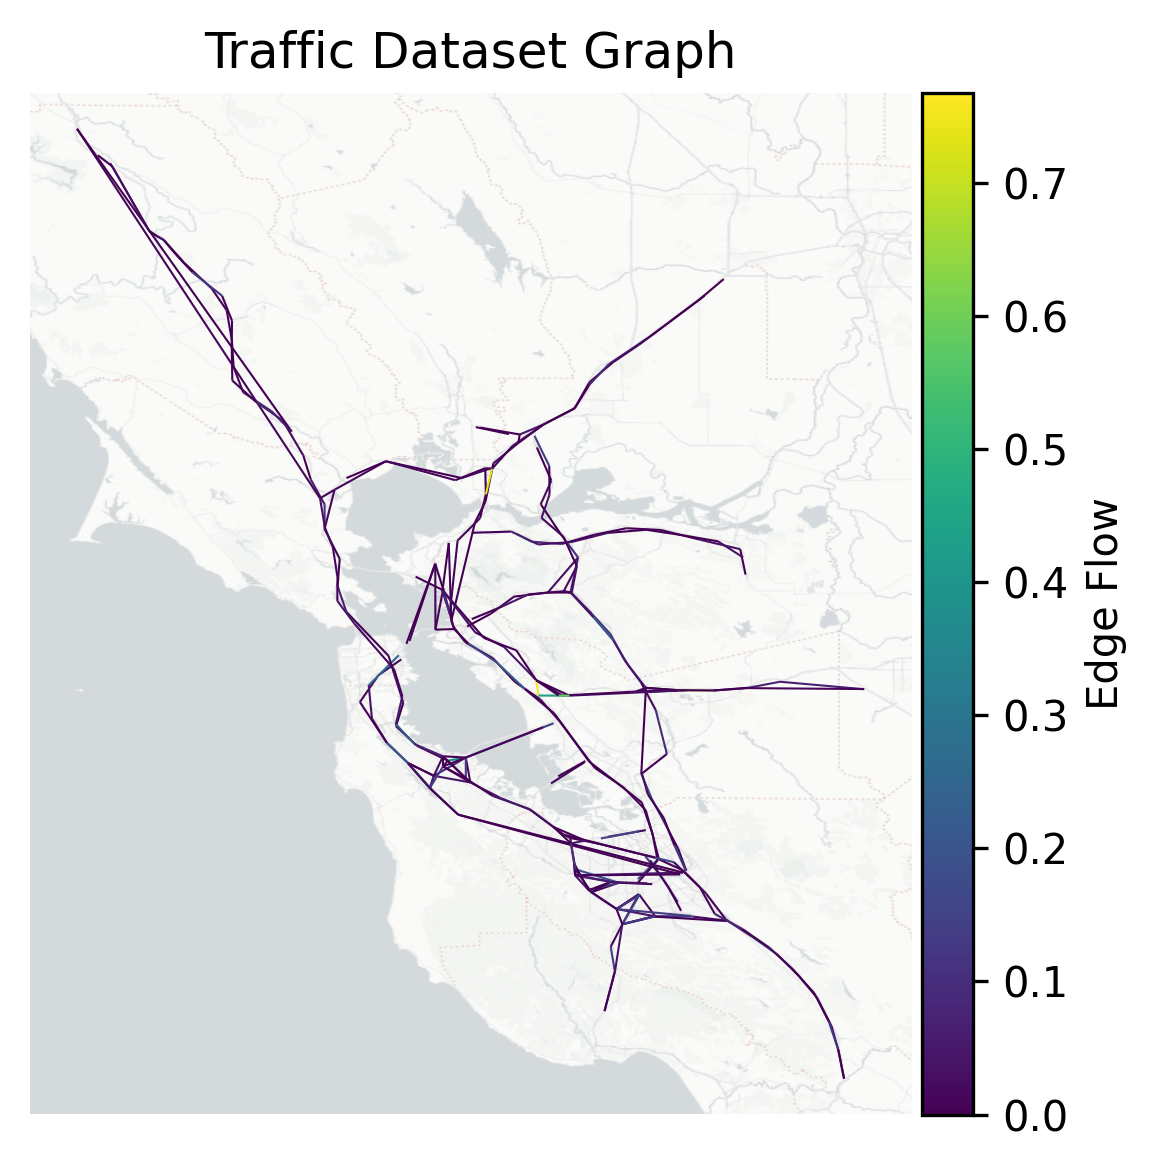

In [148]:
i = 120

plot_graph_with_basemap(G, c=data[i, :, 0], edge_c=edge_x[i, :, 0], s=0)
# plot_graph_with_basemap(G, c=data[i, :, 0], edge_c=B1.T @ x[i, :, 0], s=0)

In [184]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection, PolyCollection
import contextily as cx
from pyproj import Transformer

def plot_sc2_with_basemap(
    G,
    c='black',                   # node color or array (kept from your code)
    edge_c='darkgray',           # edge colors or array
    triangles=None,              # iterable of 3-tuples of node IDs (filled faces)
    triangle_c='tab:blue',             # None or array-like, one value per triangle
    face_alpha=0.25,             # triangle face transparency
    face_edgecolor=None,         # outline color for triangles; None -> no outline
    buffer_km=10,
    source=cx.providers.CartoDB.PositronNoLabels,
    s=3, 
    dpi=100,
):
    """
    Plot a NetworkX graph whose nodes have 'Longitude' and 'Latitude' (degrees),
    with a basemap background and (optionally) filled triangle faces (2-simplices).
    """

    # 1) grab lon/lat from node attrs
    nodes = list(G.nodes())
    lons = np.array([G.nodes[n]["Longitude"] for n in nodes], dtype=float)
    lats = np.array([G.nodes[n]["Latitude"] for n in nodes], dtype=float)

    # 2) reproject to Web Mercator (meters)
    transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)
    xs, ys = transformer.transform(lons, lats)
    pos3857 = {n: (x, y) for n, x, y in zip(nodes, xs, ys)}

    # 3) build edge segments for fast plotting
    segs = []
    for u, v in G.edges():
        x1, y1 = pos3857[u]
        x2, y2 = pos3857[v]
        segs.append([(x1, y1), (x2, y2)])

    # 4) figure extents + buffer (meters)
    xmin, xmax = xs.min(), xs.max()
    ymin, ymax = ys.min(), ys.max()
    buf = max(buffer_km * 1000.0, 1.0)  # at least 1 m
    xlim = (xmin - buf, xmax + buf)
    ylim = (ymin - buf, ymax + buf)

    # 5) plot
    fig, ax = plt.subplots(figsize=(6, 6), dpi=dpi)

    # basemap first (so overlays render crisp on top)
    ax.set_xlim(*xlim); ax.set_ylim(*ylim)
    cx.add_basemap(ax, source=source, crs="EPSG:3857", attribution=False)

    # ---- TRIANGLE FACES (2-simplices) ----
    if triangles:
        # Build list of triangle vertex arrays in projected coords
        polys = []
        for (i, j, k) in triangles:
            # (optional) ensure distinct nodes and present in graph
            if i in pos3857 and j in pos3857 and k in pos3857 and len({i, j, k}) == 3:
                polys.append(np.array([pos3857[i], pos3857[j], pos3857[k]]))

        if polys:
            if isinstance(triangle_c, str):
                # constant face color
                face_colors = triangle_c
                poly = PolyCollection(
                    polys,
                    facecolors=face_colors,
                    edgecolors=face_edgecolor,
                    linewidths=0.3 if face_edgecolor else 0.0,
                    alpha=face_alpha,
                    zorder=4,  # under edges/nodes
                )
                ax.add_collection(poly)
            else:
                # colormap by values per triangle
                triangle_c = np.asarray(triangle_c)
                if triangle_c.shape[0] != len(polys):
                    raise ValueError("triangle_c must have one value per triangle.")
                tnorm = plt.Normalize(vmin=float(np.nanmin(triangle_c)),
                                      vmax=float(np.nanmax(triangle_c)))
                tcmap = plt.get_cmap('viridis')
                facecols = tcmap(tnorm(triangle_c))
                facecols[:, -1] = face_alpha  # set alpha on RGBA

                poly = PolyCollection(
                    polys,
                    facecolors=facecols,
                    edgecolors=face_edgecolor,
                    linewidths=0.3 if face_edgecolor else 0.0,
                    zorder=1,
                )
                ax.add_collection(poly)

                # colorbar for triangles
                sm_tri = plt.cm.ScalarMappable(cmap=tcmap, norm=tnorm)
                sm_tri.set_array([])
                cbar_tri = plt.colorbar(sm_tri, ax=ax, orientation='vertical', pad=0.012)
                cbar_tri.set_label('Triangle value')

    # ---- EDGES ----
    if segs:
        # allow array-valued edge colors, else use a constant
        if isinstance(edge_c, (list, tuple, np.ndarray)):
            edge_c = np.asarray(edge_c)
            en = plt.Normalize(vmin=float(np.nanmin(edge_c)),
                               vmax=float(np.nanmax(edge_c)))
            ecmap = plt.get_cmap('viridis')
            edge_colors = ecmap(en(edge_c))
            lc = LineCollection(segs, linewidths=0.6, color=edge_colors, alpha=1.0, zorder=2)
            ax.add_collection(lc)

            sm = plt.cm.ScalarMappable(cmap=ecmap, norm=en)
            sm.set_array([])
            cbar = plt.colorbar(sm, ax=ax, orientation='vertical', pad=0.01)
            cbar.set_label('Edge Flow')
        else:
            lc = LineCollection(segs, linewidths=0.6, color=edge_c, alpha=1.0, zorder=2)
            ax.add_collection(lc)

    # ---- NODES ----
    if s > 0:
        # constant or array color both supported
        ax.scatter(xs, ys, s=s, zorder=3, c=c)

    ax.set_axis_off()
    ax.set_title("Traffic Dataset Graph with 2-Simplices")
    plt.tight_layout()
    plt.show()


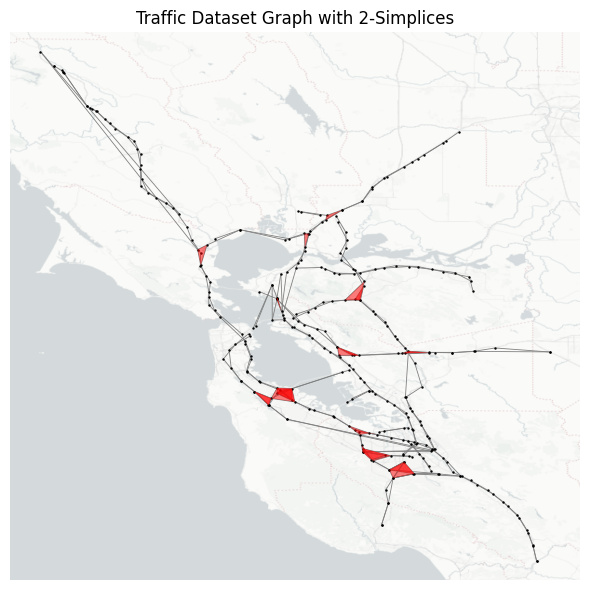

In [186]:
plot_sc2_with_basemap(G, c='black', edge_c='gray', s=0.5, triangles=F, triangle_c='red', face_alpha=0.5)

# Tutorial from code comments

# This actually generates their Laplacian!!!!!

In [165]:
# generate Hodge Laplacian for PEMSD4
PEMS_net_dataset = pd.read_csv('./distance.csv', header=0)
PEMS_net_edges = PEMS_net_dataset.values[:, 0:2]
PEMS_net_edgelist = [(int(u), int(v)) for u, v in PEMS_net_edges]
PEMS_net = nx.Graph()
PEMS_net.add_edges_from(PEMS_net_edgelist)

B1, B2 = compute_hodge_matrix(PEMS_net) # (170, 274), (274, 80)
print(B1.shape)
print(B2.shape)
hodge_Laplacian = compute_bunch_matrices(B1, B2)


assert not (hodge_Laplacian != L_used).any()

(307, 340)
(340, 29)


# This actually generates the edge features !!!!!!

In [ ]:
import os


# edge feature
net_dataset = pd.read_csv('./distance.csv', header=0)
net_edges = net_dataset.values[:, 0:2]
net_edgelist = [(int(u), int(v)) for u, v in net_edges]
net = nx.Graph()
net.add_edges_from(net_edgelist)
net_adj = nx.adjacency_matrix(net).toarray()

data_path = os.path.join('./PEMS04.npz')
data = np.load(data_path)['data'][:, :, 0:3]
edge_features_matrix = np.zeros(shape=(data.shape[0], len(PEMS_net.edges), 1)) # (num_obs, num_edges, 1)

for i in range(data.shape[0]):
    edge_features_matrix[i] = node_corr_cosine(net_adj, data[i,:,:])


assert not (edge_features_matrix != edge_x).any()

# Save for later maybe

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.collections import LineCollection
import networkx as nx

# create figure with geographic projection
width = PAGE_WIDTH / 3
height = width
fig, ax = plt.subplots(figsize=(width, height),
                       subplot_kw={'projection': ccrs.PlateCarree()})

# vertices
color = 'black'
s = 1.0
zorder = 2
node_to_lon = nx.get_node_attributes(G, 'Longitude')
node_to_lat = nx.get_node_attributes(G, 'Latitude')
lon, lat = list(node_to_lon.values()), list(node_to_lat.values())

ax.scatter(lon, lat, s=s, zorder=zorder, c=color,
           transform=ccrs.PlateCarree())

# edges
color = 'tab:grey'
linewidth = 0.5
zorder = 1
alpha = 1.0

lines = []
for i, j in G.edges:
    lines.append([[node_to_lon[i], node_to_lat[i]],
                  [node_to_lon[j], node_to_lat[j]]])
lc = LineCollection(lines, colors=color, linewidths=linewidth,
                    zorder=zorder, alpha=alpha,
                    transform=ccrs.PlateCarree())
ax.add_collection(lc)

# basemap (vector features from Cartopy / Natural Earth)
ax.add_feature(cfeature.LAND, zorder=0)
ax.add_feature(cfeature.OCEAN, facecolor="lightblue", zorder=0)
ax.add_feature(cfeature.BORDERS, linewidth=0.5, zorder=0)
ax.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=0)

# optional: remove ticks
ax.set_xticks([])
ax.set_yticks([])

# save (PDF will now be vector graphics!)
# save_figure(fig, "initial_graph.pdf")
